# Konvolucijske neuronske mreže (CNN)

Osnovni pojmovi kod konvolucijskih neuronskih mreža:
 - Konvolucija
 - Sažimanje (pooling)

In [118]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

In [119]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


### Konvolucija*

Konvolucija u neuronskim mrežama je matematička operacija koja prima dva skupa podataka, ulazni skup (sliku ili značajke) i filter (kernel).

Filter je 2D matrica realnih brojeva. Filter se primjenjuje na gornji lijevi kut ulaznog skupa, pomiče se određeni broj elemenata u desno, to se ponavlja do kraja retka, pa se pomiče prema dolje itd. Filter se primjenjuje na način da se svaki element filtera pomnoži s *preklopljenim* elementom ulaznog skupa te se tako dobiveni brojevi zbroje. Taj novi broj je jedan element izlaznog skupa podataka. Filter se uči za vrijeme treniranja konvolucijske neuronske mreže.

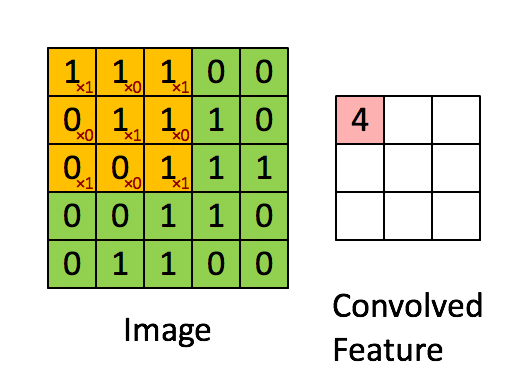






**Ovdje se radi o 2D konvoluciji, ali slični pojmovi i operacije se mogu primijeniti i kod 3D konvolucija*.

Postoje razni parametri konvolucijskih slojeva u neuronskim mrežama. U nastavku su nabrojani neki od njih, a o ostalima možete pročitati [ovdje](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

- broj ulaznih kanala (*in_channels*) - broj kanala ulazne slike/značajki, primjerice 3 za slučaj RGB slike
- broj izlaznih kanala (*out_channels*)
- veličina kernela/filtera (*kernel_size*) - dimenzije kernela
- *stride* - broj piksela koliko se kernel pomiče pri konvoluciji
- *padding* - broj piksela koji se dodaju na rub ulaznih podataka

Probajmo primijeniti konvoluciju na nekakvu sliku.

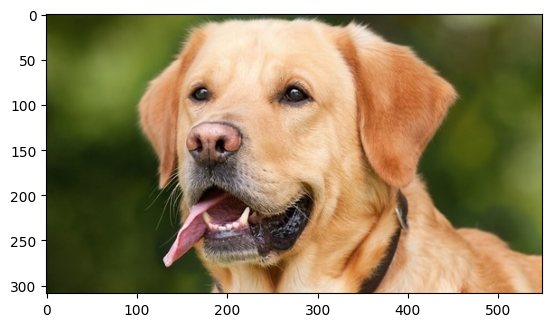

In [120]:
link = "https://www.hindustantimes.com/ht-img/img/2023/08/25/550x309/international_dog_day_1692974397743_1692974414085.jpg"
input_image = imread(link)
plt.imshow(input_image)
plt.show()

In [121]:
transform = transforms.Compose([
    transforms.ToTensor()
])
input_tensor = transform(input_image)

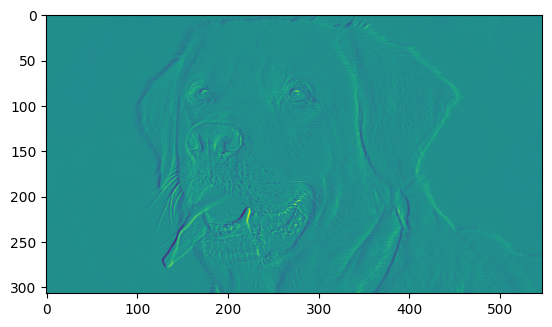

In [122]:
convolution = nn.Conv2d(3, 1, 3)
out = convolution(input_tensor)
out_image = out.detach().numpy().transpose(1, 2, 0)
plt.imshow(out_image)
plt.show()

Gore je prikazan izlaz iz konvolucije nasumičnih filtera, možemo ispisati te filtere. Također možemo i napraviti svoje filtere te ih primijeniti na ulaznu sliku.

In [123]:
convolution.weight

Parameter containing:
tensor([[[[-0.0586, -0.0239, -0.1459],
          [ 0.1567,  0.1570,  0.1084],
          [ 0.0538, -0.1333, -0.1232]],

         [[ 0.1758, -0.1446, -0.0276],
          [ 0.1801, -0.1001, -0.0152],
          [-0.1156,  0.0087,  0.0175]],

         [[-0.0175, -0.0358,  0.0889],
          [ 0.1090,  0.1650, -0.1789],
          [ 0.0736, -0.0992, -0.0752]]]], requires_grad=True)

In [124]:
our_kernel = [[[[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]],
               [[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]],
               [[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]]]]
our_kernel = nn.Parameter(torch.Tensor(our_kernel))
convolution.weight = our_kernel

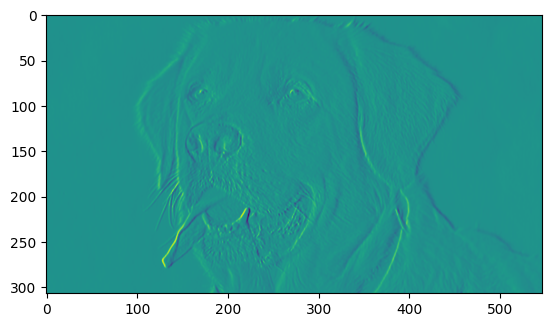

In [125]:
out = convolution(input_tensor)
out_image = out.detach().numpy().transpose(1, 2, 0)
plt.imshow(out_image)
plt.show()

Možemo primijetiti da smo pomoću gore definiranog filtera detektirali vertikalne rubove na ulaznoj slici.

### Sažimanje

Sloj sažimanja (*pooling layer*) sažima ulazne podatke te im tako smanjuje dimenzije. Primjenjuje se u konvolucijskim neuronskim mrežama nakon jednog ili više konvolucijskih slojeva. Postoje [razni](https://pytorch.org/docs/stable/nn.html#pooling-layers) načini sažimanja, ali najčešći je [*max pooling*](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).

*Max pooling* jednostavno uzima određeni segment ulazne matrice i bira najveću vrijednost koja se upisuje u izlaznu matricu. *Max pooling* sloj ima nekoliko parametara, a neki od njih su:
 - `kernel_size` - veličina prozora (kernela), može biti jedan broj ili *tuple*
 - `stride` - broj piksela koliko se prozor pomiče, može biti jedan broj ili *tuple*, zadano je da je jednako veličini prozora

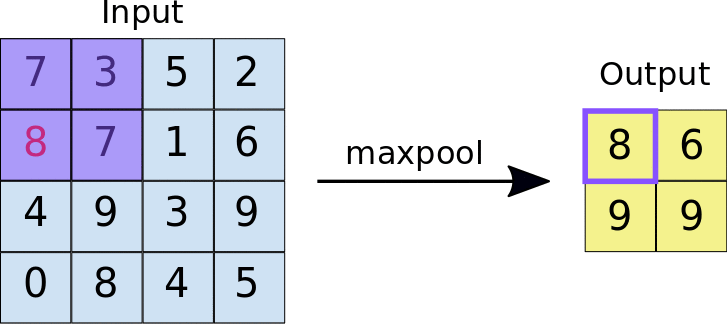

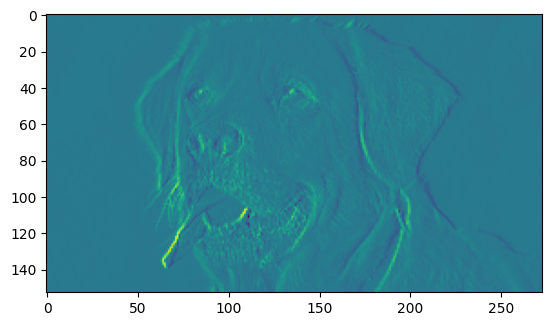

In [126]:
## TODO
## Implement the max pooling layer and use it on the above image of edges
## Check the input and output shapes and how they differ depending on the
## max pooling kernel size


max_pool = nn.MaxPool2d(
    kernel_size=2, stride=None, padding=0,
)

out = max_pool(out)
out_image = out.detach().numpy().transpose(1, 2, 0)
plt.imshow(out_image)
plt.show()

### Konvolucijska neuronska mreža

Standardna konvolucijska mreža je kombinacija 3 vrste slojeva:
 - Konvolucijski slojevi
 - Slojevi sažimanja
 - Potpuno povezani slojevi

Naravno, primjenjuju se razne aktivacijske funkcije nakon konvolucijskih i potpuno povezanih slojeva. Također se koriste i drugi slojevi, koje ćemo odraditi u budućim LV-ovima, povratne veze itd.

CNN-ovi su često izgrađeni na način da se nizaju konvolucijski slojevi popraćeni slojem sažimanja, zatim se opet nizaju konvolucijski slojevi popraćeni slojem sažimanja, što se ponavlja određeni broj puta te se na kraju izlaz iz posljednjeg sloja sažimanja provlači kroz potpuno povezane slojeve. Primjer ovakve jedne mreže (VGG-16) je prikazan na slici. Na ovom primjeru je jasno vidljivo kako se prve dvije dimenzije podataka smanjuju prolaskom kroz mrežu, a treća dimenzija, broj kanala, se povećava. Također je važno naglasiti da je, prije dodavanja potpuno povezanih slojeva, potrebno dodati [sloj za izravnavanje (*flatten*)](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html).

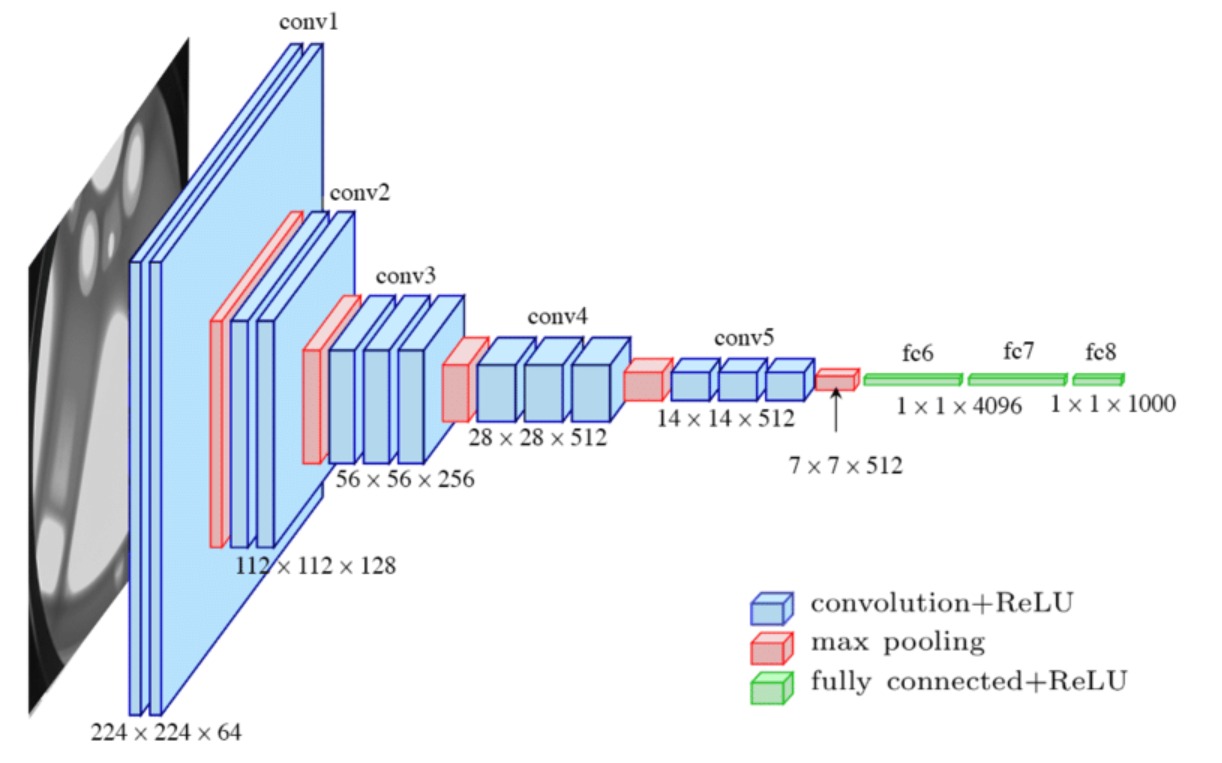

## Zadatak

Potrebno je izraditi i istrenirati konvolucijsku neuronsku mrežu na CIFAR-10 podatkovnom skupu.

CIFAR-10 je podatkovni skup koji se sastoji od 60000 slika u boji veličine 32x32. Svaka od ovih slika je klasificirana u jednu od 10 klasa. Podatkovni skup je podijeljen na skup za treniranje (50000 slika) i skup za testiranje (10000). Potrebno je skup za treniranje dodatno podijeliti na skup za treniranje (40000) i skup za validaciju (10000). Ovo možete učiniti pomoću sljedeće naredbe:

`trainset, valset = torch.utils.data.random_split(whole_trainset, [40000, 10000])`

Taj [podatkovni skup](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) se može vrlo lagano dohvatiti pomoću *torchvision* biblioteke.

In [127]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 512

whole_trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
## TODO
trainset, valset = torch.utils.data.random_split(whole_trainset, [40000, 10000])
## divide the trainset into trainset and valset
## containing 40000 and 10000 images respectively

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
    )

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat','deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


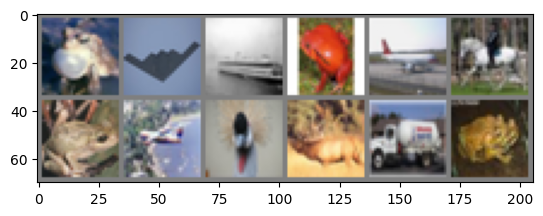

frog  plane ship  frog  plane horse frog  plane bird  deer  truck frog 


In [128]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images[:12]
labels = labels[:12]

# show images
imshow(torchvision.utils.make_grid(images, nrow=6))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(12)))

#### Mreža

Implementirajte neuronsku mrežu koja se sastoji od tri konvolucijska sloja, svaki od kojih je popraćen ReLU aktivacijskom funckijom i *max pooling* slojem. Za *max pooling* koristite kernel veličine 2x2. Brojeve filtera u konvolucijskim slojevima odaberite proizvoljno (nemojte odabrati prevelike brojeve za ovaj zadatak).

Svi konvolucijski slojevi koriste sljedeće parametre:
 - Veličina filtera (kernela): 3x3
 - *stride*: 1
 - *padding*: 'same'

Nakon konvolucijskih slojeva, dodajte tri potpuno povezana sloja s proizvoljnim brojem neurona. Napomena: Posljednji sloj treba imati 10 izlaza za 10 klasa i ne treba imati aktivacijsku funkciju.

Mreža će se koristiti za rad na podatkovnom skupu koji sadrži slike veličine 32x32, stoga prilagodite potpuno povezane slojeve tim dimenzijama.



In [129]:
## TODO
## Implement the convolutional neural network

class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.conv_layer_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.conv_layer_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')

        self.conv_layer_act_func = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 2)


        self.flatten = nn.Flatten()


        self.hidden_layer_1 = nn.Linear(4*4*64, 10)
        self.hidden_layer_2 = nn.Linear(10, 10)

        self.hidden_layer_act_func = nn.ReLU()


        self.output_layer = nn.Linear(10, 10)


    def forward(self, x):

        x = self.conv_layer_1(x)
        x = self.conv_layer_act_func(x)
        x = self.max_pool(x)

        x = self.conv_layer_2(x)
        x = self.conv_layer_act_func(x)
        x = self.max_pool(x)

        x = self.conv_layer_3(x)
        x = self.conv_layer_act_func(x)
        x = self.max_pool(x)


        x = self.flatten(x)


        x = self.hidden_layer_1(x)
        x = self.hidden_layer_act_func(x)

        x = self.hidden_layer_2(x)
        x = self.hidden_layer_act_func(x)


        x = self.output_layer(x)

        return x

Nakon što ste definirali mrežu i podatkovne skupove za treniranje i testiranje, vrijeme je za treniranje mreže. Primijenite znanja stečena u prvoj laboratorijskoj vježbi kako biste istrenirali VGG-16 neuronsku mrežu na CIFAR-10 podatkovnom skupu. Za funkciju gubitka koristite [gubitak unakrsne entropije (*cross-entropy loss*)](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [130]:
# Initialise the CNN model so that it's parameters can be passed to the optimizer,
# print it's parametres and put it to the device

model = CNN()

print(model)
print('Parameters:')
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

model.to(device)

## TODO
## Define the loss function and the optimizer

loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

CNN(
  (conv_layer_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer_act_func): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer_1): Linear(in_features=1024, out_features=10, bias=True)
  (hidden_layer_2): Linear(in_features=10, out_features=10, bias=True)
  (hidden_layer_act_func): ReLU()
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)
Parameters:
Parameter conv_layer_1.weight, shape torch.Size([16, 3, 3, 3])
Parameter conv_layer_1.bias, shape torch.Size([16])
Parameter conv_layer_2.weight, shape torch.Size([32, 16, 3, 3])
Parameter conv_layer_2.bias, shape torch.Size([32])
Parameter conv_layer_3.weight, shape torch.Size([64, 32, 3, 3])
Parameter conv_layer_3.bias

Za razliku od prve vježbe, ovdje je potrebno dodati i kontinuirano praćenje vrijednosti funkcije gubitka na skupovima za treniranje i validaciju po epohama. Kako biste ovo postigli, možete kumulativno zbrajati vrijednost funkcije gubitka u svakoj iteraciji treniranja.

Prilikom treninga, na kraju svake epohe izračunajte točnost modela na skupovima za treniranje i validaciju. Hint: Koristite istu funkciju za izračun vrijednosti funkcije gubitka (loss) i za točnost na validacijskom skupu.

Ove vrijednosti možete odmah ispisivati na ekran, ali je bitno da ih spremite u varijable kojima ćete moći poslije pristupiti zbog vizualizacije i analize (možete te varijable vratiti kao izlaze iz funkcije za treniranje).

Koristite tqdm za praćenje tijeka treniranja za svaku epohu posebno (za razliku od praćenja tijeka treniranja za sve epohe zajedno). To možete učiniti na sljedeći način:

`for data_inputs, data_labels in tqdm(data_loader, 'Epoch %d'%(epoch + 1)):`,

gdje je `epoch` broj epohe za koju se ispisuje tijek.


In [131]:
def eval_model(model, data_loader, loss_module):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    ## TODO
    ## Calculate loss for the whole dataset

    loss = 0.0 # Init loss

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)

            #TODO
            loss += loss_module(preds, data_labels).item() * len(data_inputs)
            #print(loss)
            preds = torch.argmax(preds.data, dim=1)

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (preds == data_labels).sum().item()
            num_preds += data_labels.shape[0]
    # TODO
    loss /= len(data_loader.dataset)
    acc = true_preds / num_preds

    return acc, loss

In [132]:
## TODO
## Train the network
def train_model(model, optimizer, train_data_loader, val_data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    #TODO
    true_preds, num_preds = 0., 0.
    running_val_acc = []
    running_val_loss = []
    running_train_loss = []
    running_train_acc = []

    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in tqdm(train_data_loader, 'Epoch %d'%(epoch + 1)):

            ## Step 1: Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels)

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
        ## TODO
        ## Calculate loss and accuracy for both datasets
        ## Store the accuracies and losses for both datasets
        train_acc, train_loss = eval_model(model, train_data_loader, loss_module)
        running_train_loss.append(train_loss)
        running_train_acc.append(train_acc)

        val_acc, val_loss = eval_model(model, val_data_loader, loss_module)
        running_val_loss.append(val_loss)
        running_val_acc.append(val_acc)

        print(f"Train Accuracy:      {100.0*train_acc:4.2f}%")
        print(f"Train Loss:          {str(train_loss)}")
        print("---------------------------------------------")
        print(f"Validation Accuracy: {100.0*val_acc:4.2f}%")
        print(f"Validation Loss:     {str(val_loss)}")


        model.train()

    return running_val_acc, running_val_loss, running_train_loss, running_train_acc

In [133]:
def visualize_training(train_loss, val_loss, train_acc, val_acc):
  plt.figure(figsize=[4,3])
  plt.plot(train_loss,'r',linewidth=1.0)
  plt.plot(val_loss,'b',linewidth=1.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[4,3])
  plt.plot(train_acc,'r',linewidth=1.0)
  plt.plot(val_acc,'b',linewidth=1.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Train Accuracy:      10.04%
Train Loss:          2.303411561203003
---------------------------------------------
Validation Accuracy: 9.84%
Validation Loss:     2.303794919204712


Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Train Accuracy:      9.96%
Train Loss:          2.30376787071228
---------------------------------------------
Validation Accuracy: 10.17%
Validation Loss:     2.304175605773926


Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Train Accuracy:      9.96%
Train Loss:          2.3064869201660154
---------------------------------------------
Validation Accuracy: 10.17%
Validation Loss:     2.306674357223511


Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Train Accuracy:      10.08%
Train Loss:          2.305511278152466
---------------------------------------------
Validation Accuracy: 9.69%
Validation Loss:     2.3067514781951903


Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Train Accuracy:      10.02%
Train Loss:          2.3085063285827636
---------------------------------------------
Validation Accuracy: 9.94%
Validation Loss:     2.3088074066162108


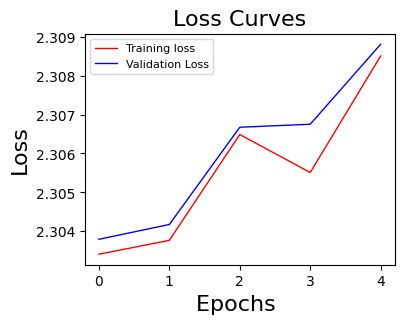

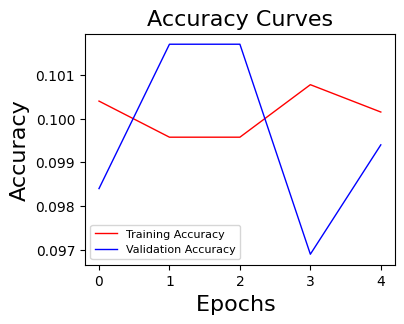

In [134]:
## TODO
## Visualize the loss and accuracy throughout the training process
val_acc, val_loss, train_loss, train_acc = train_model(model, optimizer, trainloader, valloader, loss_module, 5)
visualize_training(train_loss, val_loss, train_acc, val_acc)

Istestirajte istreniranu neuronsku mrežu na skupu za testiranje, ispišite ukupnu točnost i vizualizirajte neke od predikcija.

In [135]:
## TODO
## Test the network
eval_model(model, testloader, loss_module)

(0.1, 2.308566612625122)